In [1]:
import torch
import torch.nn as nn


def noise_images(x, t):
    beta = torch.linspace(1e-4, 0.02, 1000)
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0)

    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1. - alpha_hat[t])[:, None, None, None]

    epsilon = torch.rand_like(x)
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon


def pos_encoding(t, channels):
    even_inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2).float() / channels))
    odd_inv_freq = 1.0 / (10000**(torch.arange(1, channels, 2).float() / channels))

    pos_even_enc_a = torch.sin(t.repeat(1, channels // 2) * even_inv_freq)
    pos_odd_enc_b = torch.cos(t.repeat(1, channels // 2) * odd_inv_freq)

    pos_enc = torch.cat([pos_even_enc_a, pos_odd_enc_b], dim=-1)
    return pos_enc


In [10]:
t = torch.randint(low=1, high=1000, size=(5,))
images = torch.randn(5, 64, 64)
x_t, noise = noise_images(images, t)
# x_t shape is (5,5,64,64)
# noise shape is (5,64,64)

In [11]:
time_dim, emb_dim = 256, 256
out_channels = 128
t = t.unsqueeze(-1).type(torch.float)
t = pos_encoding(t, time_dim) # (5,256)

In [17]:
emb_layer = nn.Sequential(nn.SiLU(),nn.Linear(emb_dim, out_channels))
emb_layer(t)

torch.Size([5, 128])

In [16]:
x_t.shape

torch.Size([5, 5, 64, 64])

In [19]:
channels = 5
size = 16

x_t.view(-1, channels, size * size).swapaxes(1,2).shape
# 

torch.Size([80, 256, 5])

In [21]:
layer = nn.LayerNorm([5])
x = torch.randn(5, 5, 64, 64)
k = torch.randn(80,256,5)
layer(k).shape
self_mha = nn.MultiheadAttention(5, 5, batch_first=True)
self_mha(k,k,k)[0] + k

ff_self = nn.Sequential(
    nn.LayerNorm([5]),
    nn.Linear(5, 5),
    nn.GELU(),
    nn.Linear(5, 5)
)

In [28]:
# ff_self(self_mha(k,k,k)[0] + k).shape
# 
torch.randn(80,256,5).swapaxes(2, 1).view(-1, 5, 16, 16).shape

torch.Size([80, 5, 16, 16])

In [32]:
all_images_in_this_epoch = torch.tensor(())

In [31]:
image1 = images[0]
image2 = images[1]
image2.shape

torch.Size([64, 64])

In [33]:
all_images_in_this_epoch = torch.cat((all_images_in_this_epoch, images), 0)
all_images_in_this_epoch

tensor([[[ 1.2888,  0.1140, -0.6094,  ..., -0.3752,  0.6831,  1.4313],
         [-1.7713, -0.4711, -0.8615,  ...,  0.6954,  0.1747,  0.4515],
         [-1.9272, -1.3402,  0.0332,  ..., -0.1877,  1.4132,  1.6464],
         ...,
         [ 1.1612,  1.2506,  0.5571,  ..., -0.2541, -0.2183, -0.1054],
         [ 1.2593,  1.2331,  0.4734,  ..., -0.7725,  0.1185,  0.7151],
         [-0.9877,  1.6190, -0.4728,  ..., -2.0086,  0.4671,  2.1848]],

        [[ 0.1141,  0.6522,  0.6613,  ..., -1.0417,  0.0193,  0.6993],
         [ 0.8225,  1.3465,  0.6460,  ..., -1.8531,  1.6483, -0.4997],
         [-0.9926, -0.6115, -0.5745,  ..., -0.3355, -0.1471, -0.8726],
         ...,
         [-0.5540,  0.4068,  1.1737,  ..., -0.4305, -1.6232,  0.9602],
         [ 0.3567,  1.0157,  0.5524,  ...,  0.1461,  1.5089,  0.1806],
         [ 0.3242,  0.8523, -0.2997,  ...,  1.0955,  0.6705,  0.0528]],

        [[-0.3678, -0.2385,  1.3402,  ...,  1.2366, -0.6441, -1.3400],
         [ 0.2337,  0.9571, -1.3031,  ...,  0

In [30]:
all_images_in_this_epoch = torch.cat((all_images_in_this_epoch, image2), -2)
all_images_in_this_epoch

tensor([[ 1.2888,  0.1140, -0.6094,  ..., -0.3752,  0.6831,  1.4313],
        [-1.7713, -0.4711, -0.8615,  ...,  0.6954,  0.1747,  0.4515],
        [-1.9272, -1.3402,  0.0332,  ..., -0.1877,  1.4132,  1.6464],
        ...,
        [-0.5540,  0.4068,  1.1737,  ..., -0.4305, -1.6232,  0.9602],
        [ 0.3567,  1.0157,  0.5524,  ...,  0.1461,  1.5089,  0.1806],
        [ 0.3242,  0.8523, -0.2997,  ...,  1.0955,  0.6705,  0.0528]])

In [1]:
from datasets import load_dataset
ds = load_dataset("uoft-cs/cifar10")
ds

/workspaces/codespaces-blank/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
next(iter(DataLoader(ds['train'], batch_size=12, shuffle=True)))

In [62]:
import torchvision.transforms as transforms

imggg = ds['train']['img'][0]
transform = transforms.Compose([transforms.ToTensor()])
tensor = transform(imggg)
tensor.shape

torch.Size([3, 32, 32])

In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(ds['train'], batch_size=12, shuffle=True)
for train_features in loader:
    print(train_features)
    # print(train_labels)

In [2]:
import torch
# import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

tensor_x = torch.stack(list(map(lambda PILimg: transform(PILimg), ds['train']['img'])))
tensor_y = torch.Tensor(ds['train']['label'])

my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset)

In [4]:
for train_features, train_labels in my_dataloader:
    print(train_features)
    print(train_labels)
    break

tensor([[[[0.6980, 0.6980, 0.6980,  ..., 0.6667, 0.6588, 0.6471],
          [0.7059, 0.7020, 0.7059,  ..., 0.6784, 0.6706, 0.6588],
          [0.6941, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6549],
          ...,
          [0.4392, 0.4431, 0.4471,  ..., 0.3922, 0.3843, 0.3961],
          [0.4392, 0.4392, 0.4431,  ..., 0.4000, 0.4000, 0.4000],
          [0.4039, 0.3922, 0.4039,  ..., 0.3608, 0.3647, 0.3569]],

         [[0.6902, 0.6902, 0.6902,  ..., 0.6588, 0.6510, 0.6392],
          [0.6980, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6510],
          [0.6863, 0.6863, 0.6902,  ..., 0.6627, 0.6549, 0.6471],
          ...,
          [0.4196, 0.4275, 0.4314,  ..., 0.3804, 0.3686, 0.3725],
          [0.4000, 0.4039, 0.4039,  ..., 0.3725, 0.3647, 0.3608],
          [0.3765, 0.3647, 0.3725,  ..., 0.3294, 0.3373, 0.3294]],

         [[0.7412, 0.7412, 0.7412,  ..., 0.7059, 0.6941, 0.6824],
          [0.7490, 0.7451, 0.7490,  ..., 0.7137, 0.7059, 0.6941],
          [0.7373, 0.7373, 0.7412,  ..., 0

In [2]:
import torch
torch.cuda.is_available()

False

In [11]:
import torch.nn as nn
from torch.nn import functional as F
import torch

class DoubleConv(nn.Module):
    '''
    Used in initial convolution of images as well as 
    at the bottom of the the U shape net.
    '''
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):

        super().__init__()
        self.residual = residual
        self.normalizing_group_num = 1
        if not mid_channels:
            mid_channels = out_channels
        
        ## The following layers are applied sequentially in the
        ## defined order as follows.
        self.double_conv = nn.Sequential(

            ## Weights of conv are learned through backpropagation
            ## We are transforming the channels number from in_channels to mid_channels
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),

            ## We normalize the values group wise by separating the channels
            ## the group number. In this case it is 1. Output's shape
            ## remains unchanged from the input shape.
            nn.GroupNorm(self.normalizing_group_num, mid_channels),

            ## Apply Gaussian error linear units
            nn.GELU(),

            ## We are transforming the channels number from mid_channels to out_channels
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),

            ## Perform group normalization once again
            ## n×c×w×h -> swh×gn where c = sg
            nn.GroupNorm(self.normalizing_group_num, out_channels)
        )


    def forward(self, x):
        ## We apply gelu when we have skip connections to the UNet decoder
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        return self.double_conv(x) 
    

class newer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = DoubleConv(in_channels, out_channels)
    

a = newer(10,20)
# a.inc[0]

nn.ModuleList([newer(10,687), DoubleConv(456, 7)])[0](torch.randn(5, 10, 687))



NotImplementedError: Module [newer] is missing the required "forward" function

In [16]:
a.load_state_dict(torch.load(PATH), strict=True)
a.double_conv

/tmp/ipykernel_17972/32075292.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a.load_state_dict(torch.load(PATH), strict=True)


Sequential(
  (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GroupNorm(1, 20, eps=1e-05, affine=True)
  (2): GELU(approximate='none')
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): GroupNorm(1, 20, eps=1e-05, affine=True)
)

In [12]:
import os
os.path.exists('./model.pt')

True

In [9]:
for p in model.parameters():
    p.detach().zero_()
    print(p)

Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
        

In [8]:
import copy
class EMA:
    def __init__(self, beta):
        self.beta = beta
        self.step = 0

    def update_model_average(self, ema_model, model):
        for curr_param, ema_param in zip(model.parameters(), ema_model.parameters()):
            old_weight, new_weight = ema_param.data, curr_param.data
            ema_param.data = self.update_average(old_weight, new_weight)
            
    ## We have a apply the smoothing where the EMA model
    ## parameters will be updated by the moving average
    ## of the old and new weights.
    def update_average(self, old_weight, new_weight):
        return old_weight * self.beta + (1 - self.beta) * new_weight
    

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


    ## At the start, even as we train the non ema model, 
    ## we just allow the ema model take copy the learnt weights
    ## from the non ema model. We don't want to over average early
    ## as this overemphasizes the the early stage weights.
    ## For simplicity, we start the averaging after 2000 steps
    ## of non ema model training (assumes that our data and 
    ## no. of epochs will exceed and best be more 2x more than 2000)
    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

ema = EMA(beta=0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

AttributeError: 'DoubleConv' object has no attribute 'requires_grad'

In [10]:
copy.deepcopy(model).eval()

DoubleConv(
  (double_conv): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GroupNorm(1, 20, eps=1e-05, affine=True)
    (2): GELU(approximate='none')
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): GroupNorm(1, 20, eps=1e-05, affine=True)
  )
)

In [71]:
class Parent1:
    def __init__(self, a, b, c=2):
        self.a = a
        self.b = b

        if c < 3:
            self.c = 567567
    
    def aaa(self, neww):
        return neww
    

class Parent2:
    def __init__(self, k=1, j=56):
        self.k = k
        self.j = j

# class childB(Parent2, Parent1):
#     def __init__(self, i):
#         super().__init__(b=3,a=4)
#         self.i = i
            
#     def bbb(self, neww):
#         return neww + 345


class childA(Parent2, Parent1):
    def __init__(self, x):
        super().__init__()
        Parent1.__init__(self, a=3, b=2)
        # Parent2.__init__(self, 657, 789)
        self.x = x
    
    def help(self):
        print(self.k)
        return self.aaa(self.c)

a = childA(546)
a.help()

1


567567

In [44]:
import cv2
import torchvision

# # Load the image
# image = cv2.imread("img1.jpeg")

img = cv2.imread('messi5.jpeg', cv2.IMREAD_GRAYSCALE)
img = cv2.GaussianBlur(img, (5,5), 0)

transforms.Resize


img_tensor = torch.tensor(img)
print(img_tensor.unsqueeze(0).shape)
image = torchvision.transforms.ToPILImage()(img_tensor.unsqueeze(0))

out = cv2.Canny(img, 50, 200, L2gradient=True)
out

torch.Size([1, 720, 830])


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [1]:
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset

def get_data_loader(batch_size, is_data_loader_shuffle):

    ## Load the cifar dataset for a set of images 
    ## from huggingface for testing purposes
    ds = load_dataset("uoft-cs/cifar10")

    ## Extra operations to convert data into a dataset and
    ## fed in dataloader
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_x = torch.stack(list(map(lambda PILimg: transform(PILimg), ds['train']['img'])))
    tensor_y = torch.LongTensor(ds['train']['label'])

    my_dataset = TensorDataset(tensor_x, tensor_y)
    my_dataloader = DataLoader(my_dataset,
                               batch_size=batch_size,
                               shuffle=is_data_loader_shuffle)
    return my_dataloader

/workspaces/diffusion_impl/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
for images, labels in get_data_loader(12, True):
    print(images.shape)
    print(images.unsqueeze(0).shape)
    tt = transforms.Compose([transforms.ToPILImage()])
    image_jpg = tt(images)
    break


img.shape

In [2]:
import torch
import cv2
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

def grey_and_blur(image):
    # images_gray = np.mean(image.numpy(), axis=1)

    # Normalize the grayscale image to the range [0, 255]
    images_gray_normalized = cv2.normalize(image.numpy(), None, 0, 255, cv2.NORM_MINMAX)
    # grayscale_trans = transforms.Grayscale(num_output_channels=1)
    blurred_image = cv2.GaussianBlur(images_gray_normalized, (3,3), 0)
    blurred_image = blurred_image.astype(np.uint8)
    return cv2.Canny(blurred_image, 50, 150)


for images, labels in get_data_loader(12, True):
    
    cv2.imshow('Original', images[0].numpy())
     
    tt = transforms.Compose([
        transforms.Lambda(lambda x: [grey_and_blur(img) for img in x])
    ])
    image_jpg = tt(images)
    # print(image_jpg[0].shape)
    # plt.subplot(122), cv2.imshow(torch.tensor(image_jpg[0]))
    break


# img = cv2.imread('messi5.jpeg', cv2.IMREAD_GRAYSCALE)
# img = cv2.GaussianBlur(img, (5,5), 0)

# img_tensor = torch.tensor(img)
# print(img_tensor.unsqueeze(0).shape)
# image = torchvision.transforms.ToPILImage()(img_tensor.unsqueeze(0))
# out = cv2.Canny(img, 50, 200, L2gradient=True)
# out





# np.nonzero(out)

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


torch.Size([32, 32, 3])
(32, 32, 3)


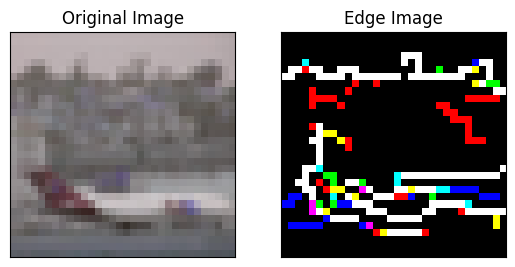

In [46]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy

for imgggg in load_dataset("uoft-cs/cifar10")['train']['img']:

    new_img = numpy.asarray(imgggg)
    (B, G, R) = cv2.split(new_img)

    gray = cv.cvtColor(new_img, cv.COLOR_BGR2GRAY)

    # edges_new = cv.Canny(gray,100,200)

    B_cny = cv2.Canny(B, 100, 200)
    G_cny = cv2.Canny(G, 100, 200)
    R_cny = cv2.Canny(R, 100, 200)

    edges_new = cv2.merge([B_cny, G_cny, R_cny])
    # edges_new = np.transpose(edges_new, (2, 0, 1))
    print(torch.tensor(edges_new).shape)

    im_rgb = cv.cvtColor(new_img, cv.COLOR_BGR2RGB)
    print(im_rgb.shape)
    plt.subplot(121),plt.imshow(im_rgb,cmap = 'Blues')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122),plt.imshow(edges_new, cmap = 'bone')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    break

In [51]:
ds = load_dataset("uoft-cs/cifar10")

def get_canny_edges(PILimg):
    trans_img = numpy.asarray(PILimg)

    (B, G, R) = cv2.split(trans_img)
    B_cny = cv2.Canny(B, 100, 200)
    G_cny = cv2.Canny(G, 100, 200)
    R_cny = cv2.Canny(R, 100, 200)
    edges = cv2.merge([B_cny, G_cny, R_cny])
    edges = np.transpose(edges, (2, 0, 1))
    return edges

transform = transforms.Compose([transforms.ToTensor()])
tensor_x = torch.stack(list(map(lambda PILimg: transform(PILimg), ds['train']['img'])))
tensor_y = torch.LongTensor(ds['train']['label'])
tensor_z = torch.stack(list(map(lambda PILimg: torch.tensor(get_canny_edges(PILimg)), ds['train']['img'])))

my_dataset = TensorDataset(tensor_x, tensor_y, tensor_z) # create your datset
my_dataloader = DataLoader(my_dataset,
                           batch_size=12,
                           shuffle=True)


for i, (images, labels, edges) in enumerate(my_dataloader):
    print(images.shape)
    print(edges.shape)
    print(labels.shape)

    break




torch.Size([12, 3, 32, 32])
torch.Size([12, 3, 32, 32])
torch.Size([12])


In [30]:
torch.randn(12,32,32).shape

torch.Size([12, 32, 32])

In [40]:
import torch.nn as nn
new_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(64, 64, kernel_size=1, padding=0)
        )

new_conv(torch.randn(12, 3, 32, 32))

tensor([[[[ 0.0993,  0.0969,  0.1196,  ...,  0.1136,  0.1127,  0.1048],
          [ 0.1060,  0.0890,  0.1041,  ...,  0.1148,  0.1229,  0.1219],
          [ 0.1034,  0.1165,  0.1026,  ...,  0.1158,  0.1068,  0.1236],
          ...,
          [ 0.0940,  0.1086,  0.0987,  ...,  0.1071,  0.1171,  0.0985],
          [ 0.1014,  0.1104,  0.1121,  ...,  0.1055,  0.1004,  0.1125],
          [ 0.1104,  0.0977,  0.1053,  ...,  0.1184,  0.1090,  0.1134]],

         [[ 0.1328,  0.1476,  0.1324,  ...,  0.1298,  0.1283,  0.1424],
          [ 0.1456,  0.1190,  0.1437,  ...,  0.1274,  0.1259,  0.1212],
          [ 0.1178,  0.1292,  0.1211,  ...,  0.1445,  0.1493,  0.1266],
          ...,
          [ 0.1209,  0.1754,  0.1464,  ...,  0.1501,  0.1143,  0.1374],
          [ 0.1271,  0.1246,  0.1274,  ...,  0.1202,  0.1482,  0.1288],
          [ 0.1284,  0.1378,  0.1389,  ...,  0.1340,  0.1307,  0.1375]],

         [[ 0.0347,  0.0372,  0.0293,  ...,  0.0292,  0.0354,  0.0415],
          [ 0.0402,  0.0357,  

<class 'numpy.ndarray'>


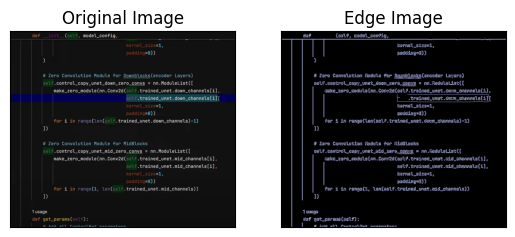

In [16]:
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('messi5.jpeg')
print(type(img))
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,100,200)

im_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(im_rgb,cmap = 'Blues')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'bone')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [51]:

# import torchvision

# # torch.tensor(img)
# aa = torchvision.transforms.Grayscale(torch.tensor(img))
# aa.numpy()

torch.randn(5,32,32).numpy()

array([[[ 9.55198407e-01,  6.26815557e-01,  1.36420786e+00, ...,
          8.46152782e-01, -1.59502506e+00, -9.63093400e-01],
        [-4.80628967e-01,  7.01862156e-01, -4.29769248e-01, ...,
         -7.97766209e-01, -4.08873528e-01, -4.31046396e-01],
        [-8.03162575e-01, -6.82195127e-01, -8.52447867e-01, ...,
         -3.09636474e-01, -4.93637145e-01,  7.30681539e-01],
        ...,
        [-2.40904346e-01,  2.84270763e-01, -2.14178652e-01, ...,
         -3.24696600e-01, -4.48550582e-01, -4.24472898e-01],
        [-1.22578454e+00,  2.22156823e-01,  1.11338472e+00, ...,
          2.89872855e-01, -4.71141160e-01, -8.09241682e-02],
        [-8.83539617e-01,  4.02206369e-02, -5.69303930e-01, ...,
         -1.09776962e+00,  1.09197187e+00, -1.14306045e+00]],

       [[-2.40280569e-01, -1.07528791e-01, -1.32566190e+00, ...,
         -1.17993462e+00, -1.92464209e+00,  1.51024914e+00],
        [ 3.58276844e-01,  1.13055790e-02, -6.92781389e-01, ...,
         -2.21898854e-01, -1.47650397e